In [2]:
import matplotlib
import matplotlib.pyplot as plt
import numpy as np
from numpy import cos, sin
import tensorflow as tf
cos, sin = tf.math.cos, tf.math.sin
from tensorflow.python.keras.engine import data_adapter

old = True

class CustomModel(tf.keras.Model):
    @tf.function
    def train_step(self, data):
        # These are the only transformations `Model.fit` applies to user-input
        # data when a `tf.data.Dataset` is provided.
        data = data_adapter.expand_1d(data)
        x, y, sample_weight = data_adapter.unpack_x_y_sample_weight(data)

        with tf.GradientTape() as tape: # Allowing automatic differentiation
            with tf.GradientTape() as tape2: # Allowing automatic differentiation
                tape2.watch(x)
                y_out = self(x, training=True) # Predicts, aka Forward pass
                tape2.watch(y_out)
                y_pred = y_out[:,0] # The first output is the predicted control.
                tape2.watch(y_pred)
                V = y_out[:,1] # The second output is the lyapunov function
            ## Computing loss function
            # NOTE:
            # This overwrites the loss function configured in compile()!!!!!!!!
            # The first part of the loss function is the old loss function which
            # Tries to make the predicted control close to the optimal control with the 
            # convex combination of the mse and msle errors.
            # The second part of the loss function is the part that tries to make the forth
            # output of the dnn a lyapunov function for the system.
            ## Calculating Vdot
            # definindo constantes
            l, I, mb, mc, at, ar = 0.43, 0.0409, 0.17, 6, .2, .2
            # Gradient of the V output wrt inputs
            dVdx = tape2.gradient(V,x)
            
            # Obtained by the chain rule.
            # Using tensordot to calculate the tensor product.
            # Since the formula is dVdx.dot(f), but there are batch_size number of lines in dVdx we need a for loop
            # to account for each element in batch_size.
            Vdot_list = []
            if x.shape[0] is None:
                i=0
                Vdot_list.append(tf.tensordot(dVdx[i:i+1,:],invert_pend(0,x[i:i+1,:],y_pred[i],l,I,mb,mc,at,ar),axes=1)[0])
            else:
                for i in range(x.shape[0]):
                    Vdot_list.append(tf.tensordot(dVdx[i:i+1,:],invert_pend(0,x[i:i+1,:],y_pred[i],l,I,mb,mc,at,ar),axes=1)[0])
            Vdot = tf.stack(Vdot_list)
            
            # Calculate the loss function
            mse = tf.keras.losses.MeanSquaredError() 
            relu = tf.keras.layers.ReLU()
            pen = 10e3
            loss = custom_loss(y,y_pred) + pen*relu(-V) + pen*relu(Vdot) # Adds the lyapunov penalty 

        # Run backwards pass.
        self.optimizer.minimize(loss, self.trainable_variables, tape=tape)
        self.compiled_metrics.update_state(y, y_pred, sample_weight)
        # Collect metrics to return
        return_metrics = {}
        for metric in self.metrics:
            result = metric.result()
            if isinstance(result, dict):
                return_metrics.update(result)
            else:
                return_metrics[metric.name] = result
        return return_metrics

def custom_loss(y_true, y_pred):
    alpha = 0.1
    msle = tf.keras.losses.MeanSquaredLogarithmicError()
    mse = tf.keras.losses.MeanSquaredError()
    return alpha*msle(y_true, y_pred)+(1-alpha)*mse(y_true, y_pred)

model = tf.keras.models.load_model('dnn_trained_batchnorm.h5',
    custom_objects={ 'custom_loss': custom_loss})

model.summary()

## Simulando o sistema e plotando as saidas
# definindo o sistema a ser integrado
def controle(t,x):
    u = model.predict(np.array([x]))
    return u

def controle_old(t,x):
    u = model_old.predict(np.array([x]))
    return u

def invert_pend(t,x,l,I,mb,mc,at,ar,is_old):
    x1,x2,x3,x4 = x
    if is_old:
        u = controle_old(t,x)
    else:
        u = controle(t,x)
    g = 9.8
    C1 = l*mb
    C2 = I+l**2*mb
    C3 = mb + mc
    x2p = (g*C1**2*cos(x3)*sin(x3)+C2*(u-at*x2)-ar*C1*cos(x3)*x4-C1*C2*sin(x3)*x4**2)/(C2*C3-C1**2*cos(x3)**2)
    x4p = (g*C1*C3*sin(x3)+C1*cos(x3)*(u-at*x2)-ar*C3*x4-C1**2*cos(x3)*sin(x3)*x4**2)/(C2*C3-C1**2*cos(x3)**2)
    dxdt = [x2, x2p, x4, x4p]
    return dxdt

# definindo constantes
l, I, mb, mc, at, ar = 0.43, 0.0409, 0.17, 6, .2, .2

# Condição inicial
x0 = [0, 0, .1415, 0]
print(str(old))
print('Estado inicial: \n '
    'x: ' +       str(x0[0]) + ' m\n'+
    'xp: ' +      str(x0[1]) + ' m/s\n\n'+
    'theta: ' +   str(x0[2]*180/np.pi) + ' o\n\n'+
    'thetap: ' +  str(x0[3]*180/np.pi) + ' o/s')

# Resolvendo o PVI
from scipy.integrate import solve_ivp
sol = solve_ivp(invert_pend, [0,30] ,x0, args=(l,I,mb,mc,at,ar, False))

# Recalcula o controle
t=sol.t
F = np.zeros_like(t)
for i in range(len(t)):
    F[i] = controle(t[i],sol.y[:,i])

# Indice de desempenho
r = 1
q = 1
Q = q*np.eye(4)
def desemp(x,u,t):
    J_em_t = x.dot(Q).dot(x)+u**2+q*t
    return J_em_t

Jt = np.zeros_like(t)
for i in range(len(t)):
    Jt[i] = desemp(sol.y[:,i],F[i],t[i])

J = np.trapz(Jt,x=t)
print('O novo indice de desempenh é: ' + str(J))


2022-12-10 22:26:32.814529: I tensorflow/compiler/xla/stream_executor/cuda/cuda_gpu_executor.cc:981] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2022-12-10 22:26:32.814900: W tensorflow/compiler/xla/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libcudart.so.11.0'; dlerror: libcudart.so.11.0: cannot open shared object file: No such file or directory; LD_LIBRARY_PATH: /app/lib
2022-12-10 22:26:32.814973: W tensorflow/compiler/xla/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libcublas.so.11'; dlerror: libcublas.so.11: cannot open shared object file: No such file or directory; LD_LIBRARY_PATH: /app/lib
2022-12-10 22:26:32.815035: W tensorflow/compiler/xla/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libcublasLt.so.11'; dlerror: libcublasLt.so.11: cannot open shared object file: No such file o

Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_1 (InputLayer)        [(None, 4)]               0         
                                                                 
 dense (Dense)               (None, 4)                 20        
                                                                 
 dense_1 (Dense)             (None, 10)                50        
                                                                 
 batch_normalization (BatchN  (None, 10)               40        
 ormalization)                                                   
                                                                 
 dense_2 (Dense)             (None, 10)                110       
                                                                 
 batch_normalization_1 (Batc  (None, 10)               40        
 hNormalization)                                             

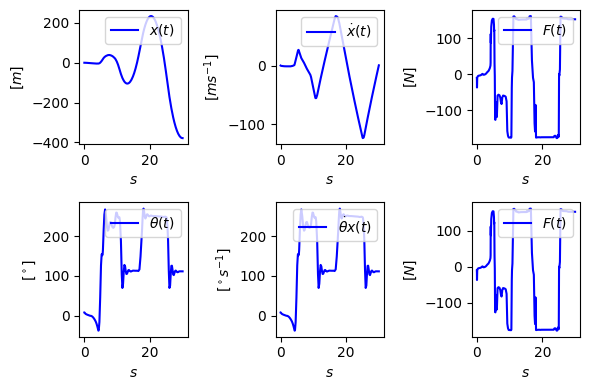

In [3]:
fig, axs = plt.subplots(2,3,figsize=(6,4), tight_layout=True)
axs[0,0].plot(t,sol.y[0,:],color=(0,0,1))
#axs[0,0].plot(t_old,sol_old.y[0,:],color=(.4,.4,1))
axs[0,0].legend((r'$x(t)$',r'$x_old(t)$'),loc=1)
axs[0,0].set_xlabel('$s$')
axs[0,0].set_ylabel('$[m]$')

axs[0,1].plot(t,sol.y[1,:],color=(0,0,1))
#axs[0,1].plot(t_old,sol_old.y[1,:],color=(.4,.4,1))
axs[0,1].legend((r'$\dot{x}(t)$',r'$\dot{x}_old(t)$'),loc=1)
axs[0,1].set_xlabel('$s$')
axs[0,1].set_ylabel('$[ms^{-1}]$')

axs[1,0].plot(t,sol.y[2,:]*180/np.pi,color=(0,0,1))
#axs[1,0].plot(t_old,sol_old.y[2,:]*180/np.pi,color=(.4,.4,1))
axs[1,0].legend((r'$\theta(t)$',r'$\theta_old(t)$'),loc=1)
axs[1,0].set_xlabel('$s$')
axs[1,0].set_ylabel('$[^\circ]$')

axs[1,1].plot(t,sol.y[2,:]*180/np.pi,color=(0,0,1))
#axs[1,1].plot(t_old,sol_old.y[2,:]*180/np.pi,color=(.4,.4,1))
axs[1,1].legend((r'$\dot{\theta}{x}(t)$',r'$\dot{\theta}_old{x}(t)$'),loc=1)
axs[1,1].set_xlabel('$s$')
axs[1,1].set_ylabel('$[^\circ s^{-1}]$')

axs[0,2].plot(t,F, color=(0,0,1))
#axs[0,2].plot(t_old,F_old, color=(.4,.4,1))
axs[0,2].legend((r'$F(t)$',r'$F_old(t)$'),loc=1)
axs[0,2].set_xlabel('$s$')
axs[0,2].set_ylabel('$[N]$')

axs[1,2].plot(t,F, color=(0,0,1))
#axs[1,2].plot(t_old,F_old, color=(.4,.4,1))
axs[1,2].legend((r'$F(t)$',r'$F_old(t)$'),loc=1)
axs[1,2].set_xlabel('$s$')
axs[1,2].set_ylabel('$[N]$')

# for i in range(3):
#     axs[i].grid(True)
plt.show()